In [1]:
import numpy as np

FreqB = (4.5, 6.0)  # GHz
widthB = (0.005, 0.01)  # GHz
fpts = np.linspace(FreqB[0], FreqB[1], 1000)  # (h,)
transitions = [(0, 1), (0, 2), (1, 2), (0, 3), (1, 3)]
weights = np.array([1.2, 0.7, 0.5, 0.25, 0.1])

In [2]:
from scqubits import Fluxonium

def calculate_spectrum(flxs, EJ, EC, EL, evals_count=4, cutoff=50):
    fluxonium = Fluxonium(EJ, EC, EL, flux=0.0, cutoff=cutoff, truncated_dim=evals_count)
    spectrumData = fluxonium.get_spectrum_vs_paramvals(
        "flux", flxs, evals_count=evals_count
    )

    return spectrumData.energy_table

def lorfunc(x, yscale, x0, gamma):
    return yscale / (1 + ((x - x0) / gamma) ** 2)


def make_spectrum(self, energies):
    # energies: (n, m')
    fs = []
    for i, j in transitions:
        fs.append(energies[:, j] - energies[:, i])
    fs = np.stack(fs, axis=1)  # (m, n)
    _, m = fs.shape

    # calculate the spectrum
    yscales = weights * np.random.uniform(0.5, 1.5, m)
    yscales *= np.random.choice([-1, 1], m)
    yscales = yscales[None, None, :]  # (1, 1, m)
    gammas = np.random.uniform(*widthB, (1, 1, m))
    xs = fpts[None, :, None]  # (1, h, 1)
    x0s = fs[:, None, :]  # (n, 1, m)
    ys = lorfunc(xs, yscales, x0s, gammas)  # (n, h, m)
    spectrum = np.sum(ys, axis=-1)  # (n, h)

    # add noise
    spectrum += np.random.normal(0, 0.35, spectrum.shape)

    return spectrum # (n, h)

In [3]:
EJb = (4.0, 6.0)
ECb = (0.5, 1.0)
ELb = (1.0, 2.0)

level = 4
total_num = 240

flxs = np.linspace(0.0, 1.0, total_num)
EJ = np.random.uniform(*EJb)
EC = np.random.uniform(*ECb)
EL = np.random.uniform(*ELb)
print("EJ, EC, EL:", EJ, EC, EL)
energies = calculate_spectrum(flxs, EJ, EC, EL, level, 50)

EJ, EC, EL: 4.203504202991242 0.8928180736681506 1.0392182654770417


Spectral data:   0%|          | 0/240 [00:00<?, ?it/s]

In [4]:
spectrum = make_spectrum(flxs, energies)

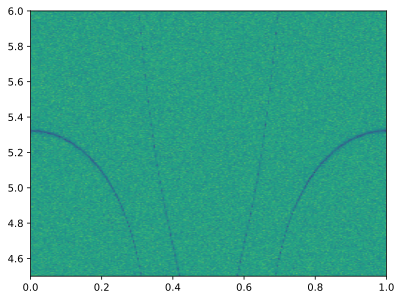

In [5]:
import matplotlib.pyplot as plt

plt.imshow(spectrum.T, aspect="auto", origin="lower"
           , extent=(flxs[0], flxs[-1], fpts[0], fpts[-1]))

# NN

In [6]:
from modules.model import PredictNet
import torch

t_spectrum = torch.tensor(spectrum.T, dtype=torch.float32)[None]
curve = PredictNet.prepare_input(t_spectrum)[0,0].numpy()

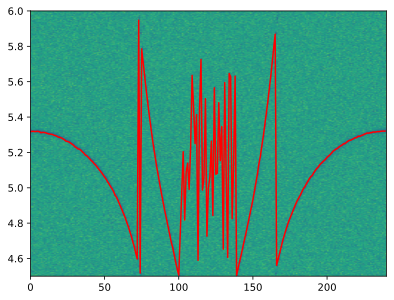

<Figure size 640x480 with 0 Axes>

In [7]:
plt.imshow(spectrum.T, aspect="auto", origin="lower", extent=(0, 240, 4.5, 6.0))
plt.plot(curve * 1.5 + 4.5, "r")
plt.ylim(4.5, 6.0)
plt.xlim(0, 240)
plt.show()
plt.savefig("spectrum.png")

In [9]:
from scipy.ndimage import gaussian_filter1d

def NormalizeData(signals2D: np.ndarray, axis=None) -> np.ndarray:
    # normalize on given axis
    mins = np.nanmin(signals2D, axis=axis, keepdims=True)
    maxs = np.nanmax(signals2D, axis=axis, keepdims=True)
    meds = np.nanmedian(signals2D, axis=axis, keepdims=True)
    return (signals2D - meds) / (maxs - mins)


def spectrum_analyze(flxs, fpts, amps, ratio):
    # use guassian filter to smooth the spectrum
    amps = gaussian_filter1d(amps, 3, axis=0)
    amps = NormalizeData(amps, 0)  # normalize on frequency axis
    amps = np.abs(amps)

    # plot max point and min point of each row
    max_ids = np.argmax(amps, axis=0)
    maxs = amps[max_ids, np.arange(amps.shape[1])]

    # max points
    max_masks = maxs >= ratio
    fs = fpts[max_ids]
    fs[~max_masks] = np.nan
    mask = ~np.isnan(fs)

    return flxs[mask], fs[mask], mask

def remove_close_points(flxs, fs, dist_ratio):
    # remove some close points
    mask = np.ones(len(flxs), dtype=bool)
    t_d2 = np.sqrt((flxs[-1] - flxs[0])**2 + (fs[-1] - fs[0])**2) * dist_ratio
    prev = 0
    for i in range(1, len(flxs)):
        d_flx = flxs[i] - flxs[prev]
        d_fs = fs[i] - fs[prev]
        d2 = np.sqrt(d_flx**2 + d_fs**2)
        if d2 < t_d2:
            mask[i] = False
        else:
            prev = i

    return flxs[mask], fs[mask]

s_flxs, s_fs, mask = spectrum_analyze(flxs, fpts, spectrum.T, 0.6)

In [10]:
import h5py as h5

with h5.File("data/train.h5", "r") as file:
    flxs = file["flxs"][:]  # type: ignore
    params = file["params"][:]  # type: ignore
    energies = file["energies"][:]  # type: ignore

def dist_to_curve(energies, s_fs, mask):
    # energies: (n, m)
    # s_fs: (n', )
    # mask: (n', )

    fs = []
    for i, j in transitions:
        fs.append(energies[:, j] - energies[:, i])
    fs = np.array(fs).T # (n, m)

    fs = fs[mask]

    dist = np.abs(fs - s_fs[:, None]) # (n, m)
    dist = np.nanmin(dist, axis=1) # (n, )

    return np.nansum(dist)

best_params = None
best_dist = float("inf")
for i in range(params.shape[0]):
    dist = dist_to_curve(energies[i], s_fs, mask)
    if dist < best_dist:
        best_dist = dist
        best_params = params[i]
print(best_params)



[4.21052632 0.88642659 1.05263158]


Spectral data:   0%|          | 0/240 [00:00<?, ?it/s]

(4.5, 6.0)

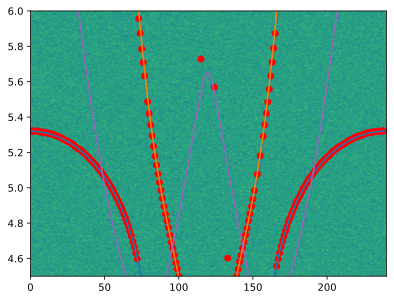

In [18]:
f_energies = calculate_spectrum(flxs, *best_params, evals_count=4, cutoff=50)
plt.imshow(spectrum.T, aspect="auto", origin="lower", extent=(0, 240, 4.5, 6.0))
for i, j in transitions:
    plt.plot(f_energies[:, j] - f_energies[:, i], label=f"{i} -> {j}")
plt.scatter((s_flxs * 240).astype(int), s_fs, c="r")
plt.ylim(4.5, 6.0)

In [ ]:
# fit the spectrumData
import torch
from torch.nn import MSELoss


model_path = "ckpt/resnet18_2.pth"
model = PredictNet(ResNet18)
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

criterion = MSELoss()

model.cuda()
criterion.cuda()
with torch.no_grad():
    nn_params = model(t_spectrum.cuda())
    true_params = (
        (EJ - EJb[0]) / (EJb[1] - EJb[0]),
        (EC - ECb[0]) / (ECb[1] - ECb[0]),
        (EL - ELb[0]) / (ELb[1] - ELb[0]),
    )
    loss = criterion(nn_params, torch.tensor([true_params], dtype=torch.float32, device="cuda"))
    print("Loss:", loss.item())

    nn_params = nn_params.cpu().numpy()[0].tolist()
    nn_params = (
        nn_params[0] * (EJb[1] - EJb[0]) + EJb[0],
        nn_params[1] * (ECb[1] - ECb[0]) + ECb[0],
        nn_params[2] * (ELb[1] - ELb[0]) + ELb[0],
    )

# print the results
print("True params:", EJ, EC, EL)
print("Fitted params:", *nn_params)

In [ ]:
f_energies = calculate_spectrum(flxs, *nn_params, level, 50)

In [ ]:

plt.imshow(spectrum.T, aspect="auto", origin="lower"
           , extent=(flxs[0], flxs[-1], fpts[0], fpts[-1]))

colors = plt.cm.rainbow(np.linspace(0, 255, level), alpha=0.8)
for i, j in transitions:
    plt.plot(flxs, f_energies[:, j] - f_energies[:, i], label=f"{i}-{j}", color=colors[i])

for i, j in transitions:
    plt.plot(flxs, energies[:, j] - energies[:, i], "--", label=f"{i}-{j}", color=colors[i])

plt.ylim(FreqB)
plt.legend()
plt.show()

# Scipy

In [47]:
from scipy.ndimage import gaussian_filter1d

def NormalizeData(signals2D: np.ndarray, axis=None) -> np.ndarray:
    # normalize on given axis
    mins = np.nanmin(signals2D, axis=axis, keepdims=True)
    maxs = np.nanmax(signals2D, axis=axis, keepdims=True)
    meds = np.nanmedian(signals2D, axis=axis, keepdims=True)
    return (signals2D - meds) / (maxs - mins)


def spectrum_analyze(flxs, fpts, amps, ratio):
    """
    flxs: 1D array, flux points
    fpts: 1D array, frequency points
    amps: 2D array, shape: (len(fpts), len(flxs))
    """
    # use guassian filter to smooth the spectrum
    amps = gaussian_filter1d(amps, 3, axis=0)
    amps = NormalizeData(amps, 0)  # normalize on frequency axis
    amps = np.abs(amps)

    # plot max point and min point of each row
    max_ids = np.argmax(amps, axis=0)
    maxs = amps[max_ids, np.arange(amps.shape[1])]

    # max points
    max_masks = maxs >= ratio
    fs = fpts[max_ids]
    fs[~max_masks] = np.nan
    mask = ~np.isnan(fs)

    return flxs[mask], fs[mask]

def remove_close_points(flxs, fs, dist_ratio):
    # remove some close points
    mask = np.ones(len(flxs), dtype=bool)
    t_d2 = np.sqrt((flxs[-1] - flxs[0])**2 + (fs[-1] - fs[0])**2) * dist_ratio
    prev = 0
    for i in range(1, len(flxs)):
        d_flx = flxs[i] - flxs[prev]
        d_fs = fs[i] - fs[prev]
        d2 = np.sqrt(d_flx**2 + d_fs**2)
        if d2 < t_d2:
            mask[i] = False
        else:
            prev = i

    return flxs[mask], fs[mask]

s_flxs, s_fs = spectrum_analyze(flxs, fpts, spectrum.T, 0.6)

In [48]:
s_flxs, s_fs = remove_close_points(s_flxs, s_fs, 0.05)

In [ ]:
plt.imshow(spectrum.T, aspect="auto", origin="lower"
           , extent=(flxs[0], flxs[-1], fpts[0], fpts[-1]))
plt.scatter(s_flxs, s_fs, c='r')

In [14]:
from scipy.optimize import minimize


def fit_spectrum(flxs, fpts, params):
    """
    Fit the fluxonium spectrum to the experimental spectrum
    flxs: 1D array of flux values, shape (n,)
    fpts: 2D array of transition frequencies, shape (n,)
    """

    def loss_func(params):
        energies = calculate_spectrum(flxs, *params, 4, cutoff=50)

        # only fit 0-1, 0-2, 1-2, 0-3, 1-3
        fs = []
        for i, j in transitions:
            fs.append(energies[:, j] - energies[:, i])
        fs = np.stack(fs, axis=1) # (n, m)
        dist = np.abs(fpts[:, None] - fs) # (n, m)
        dist = dist / weights[None, :] # make some transitions more attractive
        loss_fs = np.nanmin(dist, axis=1) # (n,)

        return np.nansum(loss_fs)

    # aim to find current curve
    res1 = minimize(
        loss_func,
        params,
        bounds=(EJb, ECb, ELb),
        method="L-BFGS-B",
        options={"maxfun": 50},
    )

    def loss_func2(params):
        energies = calculate_spectrum(flxs, *params, 4, cutoff=50)
        fs = []
        for i, j in transitions:
            fs.append(energies[:, j] - energies[:, i])
        fs = np.stack(fs, axis=1)

        dist = np.abs(fpts[:, None] - fs) # (n, m)
        min_ids = np.argmin(dist, axis=1)
        dist = dist[np.arange(len(min_ids)), min_ids] # (n,)
        dist = dist * weights[min_ids] # make some transitions more penalized

        return np.nansum(dist*0.5)

    # aim to fitting to close curve
    res2 = minimize(
        loss_func2,
        res1.x,
        bounds=(EJb, ECb, ELb),
        method="L-BFGS-B",
        options={"maxfun": 40},
    )

    return res2.x

In [ ]:
# fit the spectrumData
sp_params = fit_spectrum(s_flxs, s_fs, params=nn_params)

# print the results
print("True params:", EJ, EC, EL)
print("Fitted params:", *sp_params)

In [ ]:
f_energies = calculate_spectrum(flxs, *sp_params, level, 50)

In [ ]:
for i, j in transitions:
    plt.plot(flxs, f_energies[:, j] - f_energies[:, i], label=f"{i}-{j}")

# plot the true values in dashed lines
for i, j in transitions:
    plt.plot(flxs, energies[:, j] - energies[:, i], "--", label=f"{i}-{j}")

plt.scatter(s_flxs, s_fs, color="red")
plt.ylim(FreqB)
plt.legend()
plt.show()